In [ ]:
#Code to compute the internal energy change during impulsive encounter along straight orbit

#Computes and plots both non-perturbative and tidal limit \Delta E_{int} vs impact parameter for different values of rp/rs

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import random
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.pylab import *
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.ticker as ticker
from matplotlib.patches import BoxStyle
from scipy import integrate
from scipy import optimize
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline,interp1d
from scipy.special import erf as errorfunc
from scipy.special import gamma, factorial
from scipy.signal import argrelextrema 
from scipy.signal import savgol_filter
from matplotlib import cm
from numpy import linalg
import time
import os
import h5py
import string
from straight_functions_spherical_perturber import *

#-----------------------------------------------------------------



In [17]:
#-------Input parameters-------

mass_ratio=1                 #Subject mass Ms/Perturber mass Mp
q=1/mass_ratio
rp=1e0                       #Perturber scale radius rp in units of rs: 1e-2 -> 1e2
Rc=1                         #Truncation radius in units of rs (<bmin for point perturber)
rmax=10                      #Maximum radius for integration over subject profile; should be at least 2 times bmax; c (NFW subject); (<bmin for point perturber) 

perturber_flag=2             #perturber_flag: 1: Point mass, 2: Plummer sphere, 3: Hernquist sphere, 4: NFW, 5: Isochrone
subject_flag=1               #subject_flag: 1: Plummer sphere, 3: NFW
if (subject_flag==3):
    c1=Rc                    #NFW concentration
    c2=rmax
else:
    c1=np.nan
    c2=np.nan

impact=1 #Impact parameter

vpmin=0.1                    #Minimum Perturber velocity
vpmax=10                     #Maximum Perturber velocity
Nvp=1000
vp=np.logspace(np.log10(vpmin),np.log10(vpmax),num=Nvp)

adcorr_flag=1                #Adiabatic correction- 1: on, 0: off

#-----------------------------------------------------------------


In [5]:
#Loading particle data

Np=1000000                   #Total number of particles


if (subject_flag==3):
    hf=h5py.File('data/particle_data_NFW.h5','r')
    X=np.array(hf.get('x'))
    Y=np.array(hf.get('y'))
    Z=np.array(hf.get('z'))
    VX=np.sqrt(np.log(1+c2)-c2/(1+c2))*np.array(hf.get('vx'))
    VY=np.sqrt(np.log(1+c2)-c2/(1+c2))*np.array(hf.get('vy'))
    VZ=np.sqrt(np.log(1+c2)-c2/(1+c2))*np.array(hf.get('vz'))
    hf.close()
else:
    hf=h5py.File('data/particle_data_plummer.h5','r')
    X=np.array(hf.get('x'))
    Y=np.array(hf.get('y'))
    Z=np.array(hf.get('z'))
    VX=np.array(hf.get('vx'))
    VY=np.array(hf.get('vy'))
    VZ=np.array(hf.get('vz'))
    hf.close()

R=np.sqrt(X**2+Y**2+Z**2)
if (subject_flag==3):
    E=-0.5*(VX**2+VY**2+VZ**2)-(np.log(1+c2)-c2/(1+c2))*Phi(R,subject_flag)
else:
    E=-0.5*(VX**2+VY**2+VZ**2)-Phi(R,subject_flag)

In [ ]:
#Computing minimum encounter velocity in order to remain bound

delvcm=np.zeros(Np)                              #COM velocity along y in units of (2*G*Mp)/(rs*sigma) (Infinite subject)
bound_fraction=np.zeros(Nvp)                     #Bound fraction (general)
bound_fraction_tidal=np.zeros(Nvp)               #Bound fraction (distant tide- Gnedin et al. 1999)

if (subject_flag==3):
    xM1=Menc(Rc,subject_flag)/(np.log(1+c1)-c1/(1+c1))
    xM2=Menc(rmax,subject_flag)/(np.log(1+c2)-c2/(1+c2))
else:
    xM1=Menc(Rc,subject_flag)
    xM2=Menc(rmax,subject_flag)
Rhalf1=half_mass_radius(xM1,c1,subject_flag)     #Half mass radius (Truncation radius 1=Rc)
Rhalf2=half_mass_radius(xM2,c2,subject_flag)     #Half mass radius (Truncation radius 2=rmax)

Mtrunc1=Menc(Rc,subject_flag)                    #Mass (Truncation radius 1=Rc)
Mtrunc2=Menc(rmax,subject_flag)                  #Mass (Truncation radius 2=rmax)


delvcm=vCM(impact,rmax,rp,perturber_flag,subject_flag)*np.ones(Np)
delvx=vx(X,Y,Z,impact,rp,perturber_flag)
delvy=vy(X,Y,Z,impact,rp,perturber_flag)
A=delvx**2+(delvy-delvcm)**2
B=VX*delvx+VY*(delvy-delvcm)

delvxtidal=vxtidal(X,Y,Z,impact,rp,perturber_flag)
delvytidal=vytidal(X,Y,Z,impact,rp,perturber_flag)
delvztidal=vztidal(X,Y,Z,impact,rp,perturber_flag)
Atidal=delvxtidal**2+delvytidal**2+delvztidal**2
Btidal=VX*delvxtidal+VY*delvytidal+VZ*delvztidal

def vpfinder(vp,q,A,B,E,r,b,R_half_mass,Mtrunc,adcorr_flag,subject_flag):
    adcorr=adiabatic_correction(r,b,vp,R_half_mass,Mtrunc,adcorr_flag,subject_flag)
    return (q/vp)**2*A+(q/vp)*B-E/adcorr

C=np.zeros(Np)
Ctidal=np.zeros(Np)
if (adcorr_flag==0):
    for i in range(Np):
        if (A[i]==0 and B[i]!=0):
            C[i]=E[i]/B[i]
        elif (B[i]==0 and A[i]!=0):
            C[i]=np.sqrt(E[i]/A[i])
        elif (A[i]==0 and B[i]==0):
            C[i]=q/(0.1*vpmin)
        elif (B[i]**2+4*A[i]*E[i]<0 and A[i]<0):
            C[i]=q/(0.1*vpmin)
        elif (B[i]**2+4*A[i]*E[i]<0 and A[i]>0):
            C[i]=q/(10*vpmax)
        else:
            C[i]=np.sqrt((B[i]/(2*A[i]))**2+E[i]/A[i])-B[i]/(2*A[i])
        
        if (Atidal[i]==0 and Btidal[i]!=0):
            Ctidal[i]=E[i]/Btidal[i]
        elif (Btidal[i]==0 and Atidal[i]!=0):
            Ctidal[i]=np.sqrt(E[i]/Atidal[i])
        elif (Atidal[i]==0 and Btidal[i]==0):
            Ctidal[i]=q/(0.1*vpmin)
        elif (Btidal[i]**2+4*Atidal[i]*E[i]<0 and Atidal[i]<0):
            Ctidal[i]=q/(0.1*vpmin)
        elif (Btidal[i]**2+4*Atidal[i]*E[i]<0 and Atidal[i]>0):
            Ctidal[i]=q/(10*vpmax)
        else:
            Ctidal[i]=np.sqrt((Btidal[i]/(2*Atidal[i]))**2+E[i]/Atidal[i])-Btidal[i]/(2*Atidal[i])
else:
    #start=time.time()
    for i in range(Np):
        vpfindermin=vpfinder(0.1*vpmin,q,A[i],B[i],E[i],R[i],impact,Rhalf2,Mtrunc2,adcorr_flag,subject_flag)
        vpfindermax=vpfinder(10*vpmax,q,A[i],B[i],E[i],R[i],impact,Rhalf2,Mtrunc2,adcorr_flag,subject_flag)
        if (vpfindermin*vpfindermax>0):
            C[i]=q/(0.1*vpmin)
        else:
            C[i]=q/optimize.brentq(vpfinder,0.1*vpmin,10*vpmax,args=(q,A[i],B[i],E[i],R[i],impact,Rhalf2,Mtrunc2,adcorr_flag,subject_flag))
        
        vpfindertidalmin=vpfinder(0.1*vpmin,q,Atidal[i],Btidal[i],E[i],R[i],impact,Rhalf2,Mtrunc2,adcorr_flag,subject_flag)
        vpfindertidalmax=vpfinder(10*vpmax,q,Atidal[i],Btidal[i],E[i],R[i],impact,Rhalf2,Mtrunc2,adcorr_flag,subject_flag)
        if (vpfindertidalmin*vpfindertidalmax>0):
            Ctidal[i]=q/(0.1*vpmin)
        else:
            Ctidal[i]=q/optimize.brentq(vpfinder,0.1*vpmin,10*vpmax,args=(q,Atidal[i],Btidal[i],E[i],R[i],impact,Rhalf2,Mtrunc2,adcorr_flag,subject_flag))
        #end=time.time()
        #print ("%d\tTime taken: %f s\n" %(i,end-start))


In [ ]:
#Computing bound fraction

#start=time.time()
for i in range(Nvp):
    
    mask=vp[i]>q/C
    xbound=X[mask]
    ybound=Y[mask]
    zbound=Z[mask]
    vxbound=VX[mask]
    vybound=VY[mask]
    vzbound=VZ[mask]
    bound_fraction[i]=len(xbound)/Np
    
    
    masktidal=vp[i]>q/Ctidal
    xtidalbound=X[masktidal]
    ytidalbound=Y[masktidal]
    ztidalbound=Z[masktidal]
    vxtidalbound=VX[masktidal]
    vytidalbound=VY[masktidal]
    vztidalbound=VZ[masktidal]
    bound_fraction_tidal[i]=len(xtidalbound)/Np    
    
    #end=time.time()
    #print ("%d\tTime taken: %f s\n" %(i,end-start))

In [8]:
#Writing data in a file

hf = h5py.File('boundfraction_straight_orbit_perturber%d_subject%d_rp%.3f_massratio_%.3f_impact%.2f_adcorr%d.h5' %(perturber_flag,subject_flag,rp,mass_ratio,impact,adcorr_flag), 'w')
hf.create_dataset('vp', data=vp)
hf.create_dataset('bound_fraction', data=bound_fraction)
hf.create_dataset('bound_fraction_tidal', data=bound_fraction_tidal)
hf.close()

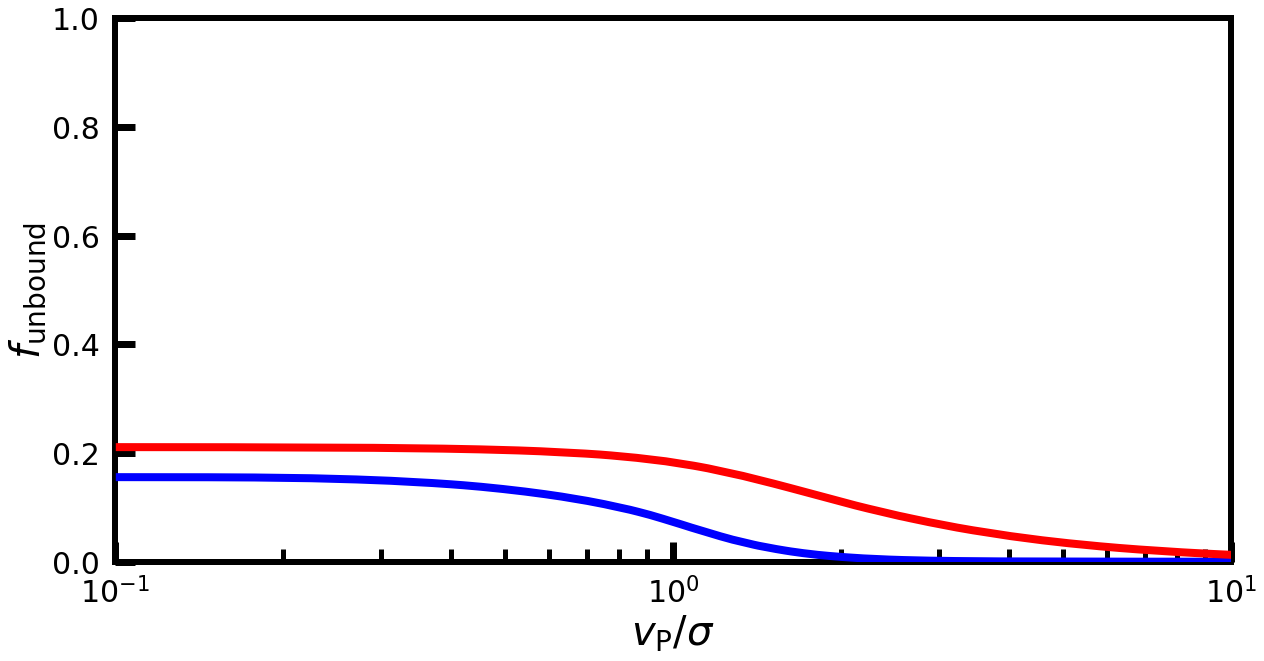

In [16]:
#Plot

fig,ax=plt.subplots(figsize=(20,10))
ax.plot(vp,1-bound_fraction,color='b',lw=8)
ax.plot(vp,1-bound_fraction_tidal,color='r',lw=8)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([vpmin,vpmax])
ax.set_ylim([0,1])
ax.tick_params(which='major', direction='in', width=7, length=20, color='k', pad=15)
ax.tick_params(which='minor', direction='in', width=5, length=13, color='k', pad=15)
ax.set_xticks(np.logspace(np.log10(vpmin),np.log10(vpmax),num=3))
ax.set_yticks(np.linspace(0,1,6))
ax.tick_params(labelsize=30)
ax.set_xlabel('$v_{\mathrm{P}}/\sigma$',fontsize=40)
ax.set_ylabel('$f_{\mathrm{unbound}}$',fontsize=40)
ax.patch.set_edgecolor('k')  
ax.patch.set_linewidth('6')

plt.savefig('Unbound_fraction_vs_vp_straight_orbit_perturber%d_subject%d_rp%.3f_massratio_%.3f_impact%.2f_adcorr%d.jpg'  %(perturber_flag,subject_flag,rp,mass_ratio,impact,adcorr_flag))
plt.show()